# Some plots of X-ray data

In [114]:
from glob import glob

import numpy as np
from astropy.table import Table
from astropy.time import Time
from astropy.io import fits
from sherpa.astro import ui
from sherpa.astro import datastack as ds

import matplotlib.pyplot as plt
%matplotlib inline

In [257]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, save
output_notebook()

Loading BokehJS ...

In [1]:
obsids = ['5', 'XMM', '6443', '7435', '7436', '7437', '7438', '13250',
          '23382', '23384', '23383', '23385', '23386', '24989']
dslist = {}

In [12]:
tgpart = ['dummy', 'heg', 'meg', 'leg']

def loadpha2(obsid):
    stack = ds.DataStack()
    dirname = glob(f'data/Chandra/tgcat/*_{obsid}*/')[0]
    pha2 = glob(dirname + '*pha2.*')
    ui.load_data(pha2[0])
    tab = Table.read(pha2[0], hdu=1, format='fits')
    # Use only first orders
    ind = np.abs(tab['TG_M']) == 1
    for row in tab[ind]:
        dataname = obsid + '_' + tgpart[row['TG_PART']] + '_' + str(row['TG_M'])
        ui.copy_data(row['SPEC_NUM'], dataname)
        m = row['TG_M']
        part = tgpart[row['TG_PART']]
        if ui.get_data().header['INSTRUME'] == 'ACIS':
            ui.load_arf(dataname, f'{dirname}{part}_{m}.arf.gz')
            ui.load_rmf(dataname, f'{dirname}{part}_{m}.rmf.gz') 
        else:  # HRC has no order-sorting
            sign = '' if m > 0 else '-'
            # It's faster to just load the top 3 orders and the later 
            # ones don't contribute much anyway.
            for num in [1,2,3]:
                ui.load_arf(dataname, f'{dirname}{part}_{sign}{num}.arf.gz', num)
                ui.load_rmf(dataname, f'{dirname}{part}_{sign}{num}.rmf.gz', num) 
        stack._add_dataset(dataname)
    # We copied all dataids to be used to new names, so delete the automatic read-in numbers
    for row in range(len(tab)):
        ui.delete_data(row + 1)
    return stack

In [15]:
# Load in order of obervations, such that dslist is sorted by time
# First Chandra
dslist['5'] = loadpha2('5')

# Then XMM
path = 'data/XMM/0112880201/pps/'
ui.load_data('XMM_R1', path + 'P0112880201R1S004SRSPEC1003.FTZ')
ui.load_data('XMM_R2', path + 'P0112880201R2S005SRSPEC1003.FTZ')
ui.load_rmf('XMM_R1', path + 'P0112880201R1S004RSPMAT1003.FTZ')
ui.load_rmf('XMM_R2', path + 'P0112880201R2S005RSPMAT1003.FTZ')
stack = ds.DataStack()
stack._add_dataset('XMM_R1')
stack._add_dataset('XMM_R2')
dslist['XMM'] = stack

# and then all the other Chandra
for o in obsids[2:]:
    dslist[o] = loadpha2(o)

statistical errors were found in file 'data/Chandra/tgcat/obs_5_tgid_4988/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background_up into a dataset from file data/Chandra/tgcat/obs_5_tgid_4988/pha2.gz
read background_down into a dataset from file data/Chandra/tgcat/obs_5_tgid_4988/pha2.gz
Multiple data sets have been input: 1-12
statistical errors were found in file 'data/XMM/0112880201/pps/P0112880201R1S004SRSPEC1003.FTZ' 
but not used; to use them, re-read with use_errors=True
statistical errors were found in file 'data/XMM/0112880201/pps/P0112880201R2S005SRSPEC1003.FTZ' 
but not used; to use them, re-read with use_errors=True
statistical errors were found in file 'data/Chandra/tgcat/obs_6443_tgid_2459/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background file data/Chandra/tgcat/obs_6443_tgid_2459/pha2_bg
read background_up into a dataset from file data/Chandra/tgcat/obs_6443_tgid_2459/pha2.gz
read background_down into a dataset f

In [29]:
ui.set_analysis("wave")

In [24]:
dat = ui.get_data("24989_leg_1")

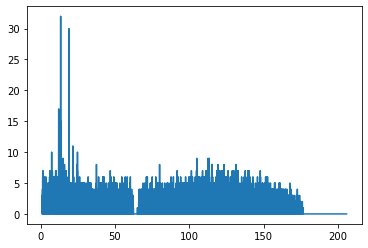

In [30]:
plt.plot(dat.get_x(), dat.get_dep())

In [38]:
import bokeh
import bokeh.colors

In [42]:
bred = bokeh.colors.groups.red()

In [47]:
# https://www.geeksforgeeks.org/how-to-use-color-palettes-in-python-bokeh/
from bokeh.palettes import Colorblind

In [53]:
obsids

['5',
 'XMM',
 '6443',
 '7435',
 '7436',
 '7437',
 '7438',
 '13250',
 '23382',
 '23384',
 '23383',
 '23385',
 '23386',
 '24989']

In [56]:
ui.notice(5, 35)

In [81]:
ui.group_width?

In [82]:
for i, o in enumerate([ '23382',
 '23384',
 '23383',
 '23385',
 '23386',
 '24989']):
    ui.group_width(f'{o}_leg_1', 3)
    ui.group_width(f'{o}_leg_-1', 3)

In [259]:
# create a new plot with a title and axis labels
p = figure(title="Chandra LETGS",
           x_axis_label="wavelength", y_axis_label="counts / bin")

for i, o in enumerate([ '23382',
 '23384',
 '23383',
 '23385',
 '23386',
 '24989']):
    datp = ui.get_data_plot(f'{o}_leg_1')
    datm = ui.get_data_plot(f'{o}_leg_-1')
    # reduce size by only plotting areas that matter
    p.line(datp.x, datp.y + datm.y,
           legend_label=o, line_width=2, color=Colorblind[8][i+1])
p.xaxis.axis_label = datp.xlabel
p.yaxis.axis_label = datp.ylabel
p.legend.title = 'OBSID'
show(p)
save(p, 'figures/newLEGTS.html')

'/melkor/d1/guenther/projects/TWHya/code/figures/newLEGTS.html'

In [167]:
xraytime = Time([(ui.get_data(dslist[o].ids[0]).header)['DATE-OBS'] for o in obsids])
xrayend = Time([(ui.get_data(dslist[o].ids[0]).header)['DATE-END'] for o in obsids])

In [183]:
hrctime = Time([fits.getval(f'data/Chandra/{o}/pha2.fits', 'DATE-OBS') for o in ['20734', '22178']])
hrcend = Time([fits.getval(f'data/Chandra/{o}/pha2.fits', 'DATE-END') for o in ['20734', '22178']])

In [213]:
filelist = glob('data/HST/all_x1dsum/alluv/HST/*/*x1dsum.fits')
hstfuv = Time([fits.getval(f, 'EXPSTART', ext=1) for f in filelist if 
               ((fits.getval(f, 'INSTRUME', 0) == 'COS') and (fits.getval(f, 'DETECTOR', 0) == 'FUV'))],
               format='mjd')
hstnuv = Time([fits.getval(f, 'EXPSTART', ext=1) for f in filelist if 
               ((fits.getval(f, 'INSTRUME', 0) == 'COS') and (fits.getval(f, 'DETECTOR', 0) == 'NUV'))],
               format='mjd')
filelist = glob('data/HST/all_x1dsum/alluv/HST/*/*flt.fits')
hststis = Time([fits.getval(f, 'EXPSTART', ext=1) for f in filelist if 
               ((fits.getval(f, 'INSTRUME', 0) == 'STIS'))],
               format='mjd')


In [247]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_timeline(dot=True):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.broken_barh([(d1, d2-d1) for d1, d2 in zip(xraytime.datetime, xrayend.datetime)], (10, 9), facecolors='tab:blue')
    ax.broken_barh([(d1, d2-d1) for d1, d2 in zip(hrctime.datetime, hrcend.datetime)], (10, 9), facecolors='tab:blue')
    if dot:
        ax.plot(hrctime.datetime, 15 * np.ones(len(hrctime)), 'o', ms=10, c='green')
        ax.plot(xraytime.datetime, 15 * np.ones(len(xraytime)), 'o', ms=10, c='blue')
    #ax.broken_barh([(10, 50), (100, 20), (130, 10)], (20, 9),
    #               facecolors=('tab:orange', 'tab:green', 'tab:red'))
    ax.plot(hststis.datetime, 21 * np.ones(len(hststis)), 's', ms=10, color='orange')
    ax.plot(hstfuv.datetime, 23 * np.ones(len(hstfuv)), 's', ms=10, color='red')
    ax.plot(hstnuv.datetime, 25 * np.ones(len(hstnuv)), 's', ms=10, color='salmon')
    ax.set_ylim(5, 28)
    #ax.set_xlim(0, 200)
    ax.set_xlabel('MJD')
    ax.set_yticks([15, 21, 23, 25])
    ax.set_yticklabels(['X-ray', 'STIS/UV', 'COS/FUV', 'COS/NUV'])
    ax.grid(True)

    ax.tick_params(axis='x', labelrotation=30)
    return fig, ax

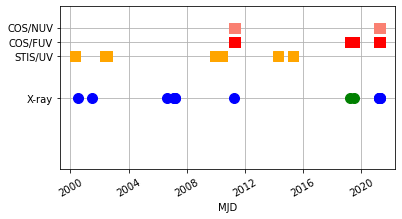

In [260]:
fig, ax = plot_timeline()
fig.savefig(f'figures/timeline.png', bbox_inches='tight')

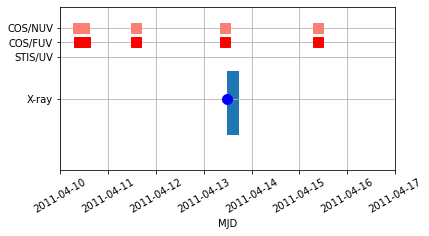

In [261]:
fig, ax = plot_timeline()
ax.set_xlim(Time('2011-04-10T00:00:00').datetime, Time('2011-04-17T00:00:00').datetime)
fig.savefig(f'figures/timeline2011.png', bbox_inches='tight')

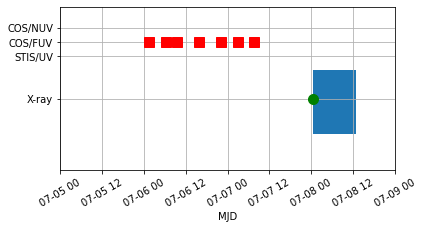

In [262]:
fig, ax = plot_timeline()
ax.set_xlim(Time('2019-07-05T00:00:00').datetime, Time('2019-07-09T00:00:00').datetime)
fig.savefig(f'figures/timeline2019.png', bbox_inches='tight')

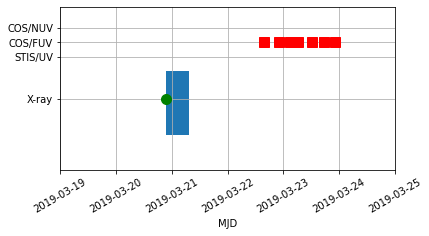

In [263]:
fig, ax = plot_timeline()
ax.set_xlim(Time('2019-03-19T00:00:00').datetime, Time('2019-03-25T00:00:00').datetime)
fig.savefig(f'figures/timeline20192.png', bbox_inches='tight')

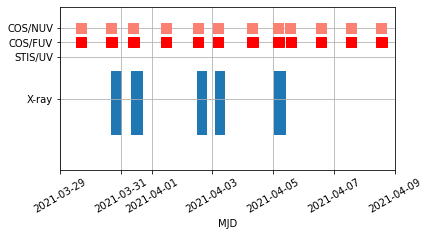

In [264]:
fig, ax = plot_timeline(dot=False)
ax.set_xlim(Time('2021-03-29T00:00:00').datetime, Time('2021-04-9T00:00:00').datetime)
fig.savefig(f'figures/timeline2021.png', bbox_inches='tight')